# Airline Flights Data Analysis

*Using the USDOT flights delays data published on Kaggle (https://www.kaggle.com/datasets/usdot/flight-delays) I investigate the following questions:*

  1. Are there any data quality issues?
  2. In terms of delays, which airlines perform the worst? Which the best? 
  3. Does airline performance change over the months of the year? Is one airline always the worst performing, or is there variability?
  4. Which routes have the highest probability of being cancelled? 

### References
Several EDA functions and modeling techniques were derived from the sources below: 
1. [Daniel Fabien] Predicting flight delays  https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial
2. Using Python for Introductory Econometrics - Florian Heiss, Daniel Brunner

#### Import + merge datasets 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 350)

df = pd.read_csv(r"C:\Users\hw501f\Downloads\UA_data\flights.csv")
airports = pd.read_csv(r"C:\Users\hw501f\Downloads\UA_data\airports.csv")
airlines = pd.read_csv(r"C:\Users\hw501f\Downloads\UA_data\airlines.csv")
airlines = airlines.rename(columns={'AIRLINE': 'AL_FULLNAME', 'IATA_CODE': 'AIRLINE'})

#convert column names to lowercase
df.columns = df.columns.str.lower()
airlines.columns = airlines.columns.str.lower()
airports.columns = airports.columns.str.lower()

#merge airlines and flights data to get full names of airlines
df = df.merge(airlines, how = 'left', on = 'airline')

#merge origin airport data onto main df
merged_df = pd.merge(df, airports, left_on='origin_airport', right_on='iata_code', how='left')
merged_df.rename(columns={'airport': 'origin_airport_name', 'city': 'origin_city', 'state': 'origin_state', 'country': 'origin_country', 'latitude': 'origin_latitude', 'longitude': 'origin_longitude'}, inplace=True)
merged_df.drop('iata_code', axis=1, inplace=True)

#merge destination airport data onto main df
merged_df = pd.merge(merged_df, airports, left_on='destination_airport', right_on='iata_code', how='left')
merged_df.rename(columns={'airport': 'destination_airport_name', 'city': 'destination_city', 'state': 'destination_state', 'country': 'destination_country', 'latitude': 'destination_latitude', 'longitude': 'destination_longitude'}, inplace=True)
merged_df.drop('iata_code', axis=1, inplace=True)

df = merged_df

#### 1. Are there any data quality issues? If so, how can you address them?
- need to create datetime for easier plotting + time series analysis
- fix departure + arrival times
- check for duplicates
- some airports are coded as integers

In [2]:
#get info on columns types and number of null and unique values

df_dtypes = pd.DataFrame(df.dtypes, columns = ['dtypes'])
null_count = df.isnull().sum().rename('null values')
null_pct = (df.isnull().sum() / df.shape[0] * 100).rename('null percent')
df_unique = df.nunique(axis=0).rename('unique vals')

result = pd.concat([df_dtypes, null_count, null_pct, df_unique], axis=1).T
result

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,al_fullname,origin_airport_name,origin_city,origin_state,origin_country,origin_latitude,origin_longitude,destination_airport_name,destination_city,destination_state,destination_country,destination_latitude,destination_longitude
dtypes,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64,object,object,object,object,object,float64,float64,object,object,object,object,float64,float64
null values,0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640,0,486165,486165,486165,486165,490770,490770,486165,486165,486165,486165,490775,490775
null percent,0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725,0,8.35467,8.35467,8.35467,8.35467,8.43381,8.43381,8.35467,8.35467,8.35467,8.35467,8.43389,8.43389
unique vals,1,12,31,7,14,6952,4897,930,930,1321,1440,1217,184,1440,550,712,675,1363,1440,185,1435,1440,1240,2,2,4,570,154,1067,695,632,14,322,308,54,1,319,319,322,308,54,1,319,319


In [3]:
#drop columns with little variability/not useful in prediciton/visualization or redundant
df = df.drop(columns = ['flight_number', 'tail_number', 'taxi_out', 
                   'wheels_off', 'air_time', 'taxi_in', 'diverted',
                  'cancellation_reason', 'air_system_delay', 'security_delay', 
                   'airline_delay', 'late_aircraft_delay', 'weather_delay', 'destination_country',
                       'origin_country'])

In [4]:
df.head()

,year,month,day,day_of_week,airline,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,scheduled_time,elapsed_time,distance,wheels_on,scheduled_arrival,arrival_time,arrival_delay,cancelled,al_fullname,origin_airport_name,origin_city,origin_state,origin_latitude,origin_longitude,destination_airport_name,destination_city,destination_state,destination_latitude,destination_longitude
0,2015,1,1,4,AS,ANC,SEA,5,2354.0,-11.0,205.0,194.0,1448,404.0,430,408.0,-22.0,0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619,Seattle-Tacoma International Airport,Seattle,WA,47.44898,-122.30931
1,2015,1,1,4,AA,LAX,PBI,10,2.0,-8.0,280.0,279.0,2330,737.0,750,741.0,-9.0,0,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Palm Beach International Airport,West Palm Beach,FL,26.68316,-80.09559
2,2015,1,1,4,US,SFO,CLT,20,18.0,-2.0,286.0,293.0,2296,800.0,806,811.0,5.0,0,US Airways Inc.,San Francisco International Airport,San Francisco,CA,37.61900,-122.37484,Charlotte Douglas International Airport,Charlotte,NC,35.21401,-80.94313
3,2015,1,1,4,AA,LAX,MIA,20,15.0,-5.0,285.0,281.0,2342,748.0,805,756.0,-9.0,0,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Miami International Airport,Miami,FL,25.79325,-80.29056
4,2015,1,1,4,AS,SEA,ANC,25,24.0,-1.0,235.0,215.0,1448,254.0,320,259.0,-21.0,0,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Seattle,WA,47.44898,-122.30931,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17432,-149.99619


#### Initial takeaways
- No columns have > 8% of their values missing except for cancellation/delay reasons (98% null). Dropping these small number of null observations seems OK, but would need to ensure missing values are random and not tied to an airline, period of time, route, etc.
- Some columns like destination/origin country have no variation (one value) and are dropped to get a clearer picture of the dataframe
- ~ 8% of my origin/destination airport information is missing despite the keys in the flights df not having missing values. Maybe there are airports present in "flights" that aren't in "airports".
- if predicting delay, later taxi out/in times are highly correlated. Dropping as to not introduce high collinearity in explanatory variables 

In [6]:
#create "date", "week_number", "sched_hour", and "dow_name" columns
df['date'] = pd.to_datetime(df[['year','month', 'day']])
df['week_number'] = df['date'].dt.strftime('%U')
df['dow_name'] = df['date'].dt.strftime('%A')


#function that assigns season based on month. May be useful for visualization
def season_cat(x):
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    return 'autumn'

#create season type column and count # of short/med/long flights
df['season'] = df['month'].apply(season_cat) 

df = df.drop(columns = 'year')

In [7]:
#check if there are airports in flights that are not in airports.'set' creates unique list of things 
unmatched_origin_airports = set(df['origin_airport']) - set(airports['iata_code'])
unmatched_destination_airports = set(df['destination_airport']) - set(airports['iata_code'])
len(unmatched_origin_airports)

608

It looks like there are some missing airports from the airports csv. It's possible to source this online, but ~8% missing probably isn't the end of the world.

In [8]:
#remove observations where airport is an integer
import re
import pandas as pd

# Check if 'origin_airport' or 'destination_airport' can be converted to numeric values
is_numeric = pd.to_numeric(df['origin_airport'], errors='coerce').notna() | pd.to_numeric(df['destination_airport'], errors='coerce').notna()

# Drop the rows where either 'origin_airport' or 'destination_airport' contains integer values
df = df[~is_numeric]

In [9]:
# duplicate_obs = df[df.duplicated()]
# duplicate_obs
# No exact duplicate observations found!

Below we write a script to transform the arrival and departure times from continuous floats to time objects e.g. 1730 --> 15:30     

In [10]:
from datetime import datetime

#write a function to convert float time to string time format
def convert_float_time(float_time):
    time_string = str(float_time).split('.')[0].zfill(4) #ensure 4 characters
    
    try:
        hour = int(time_string[:-2]) #first two will be the hour
        minute = int(time_string[-2:]) #last will be minutes
    
        if hour >= 24:
            hour = hour % 24
    
        return f"{hour:02d}:{minute:02d}:00"
    except ValueError: #return none where there are null values
        return None
    
#Apply the conversion function to the arrival_time column
df['arrival_time'] = df['arrival_time'].apply(convert_float_time) 
df['departure_time'] = df['departure_time'].apply(convert_float_time)
df['scheduled_departure'] = df['scheduled_departure'].apply(convert_float_time) 

#Combine date and scheduled departure columns into a single datetime column
df['scheduled_departure_datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['scheduled_departure'])

#get hour from the scheduled departure time
df['sched_hour'] = df['scheduled_departure_datetime'].dt.strftime('%H')

## Exploratory data analysis


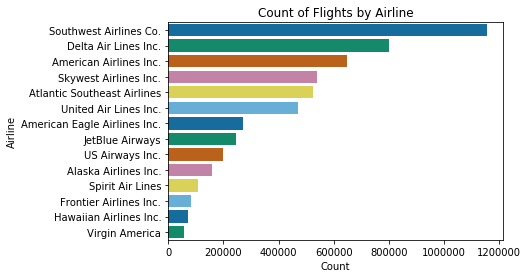

In [11]:
#get the count of all unqiue airlines
airline_counts = df['al_fullname'].value_counts().sort_values(ascending=False)

# Create a bar chart using seaborn
plt.figure(figsize=(6, 4))
sns.color_palette("colorblind")
plt.title("Count of Flights by Airline")
sns.barplot(x=airline_counts.values, y=airline_counts.index,palette="colorblind")
plt.xlabel("Count")
plt.ylabel("Airline")
plt.show()

Looks like about 1/5th of the dataset is southwest flights, which appears to be far and away the leader by count ~1.2 million. The count drops off considerably when observing airlines outside of the top 6-this could be a useful partition when looking at similarly-sized airlines. 

- How else can we compare airline size/characteristics?

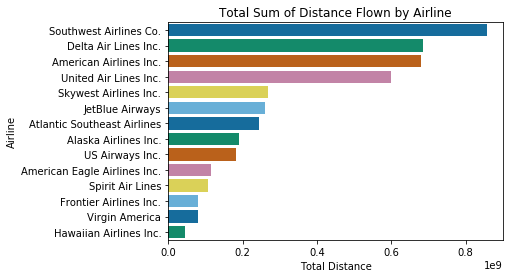

In [12]:
#calculate total distance, and plot
airline_sum_distance = df.groupby('al_fullname')['distance'].sum().sort_values(ascending=False)
# Create a bar plot using seaborn
plt.figure(figsize=(6,4))
sns.barplot(x=airline_sum_distance.values, y=airline_sum_distance.index, palette="colorblind")
plt.title("Total Sum of Distance Flown by Airline")
plt.xlabel("Total Distance")
plt.ylabel("Airline")
plt.show()

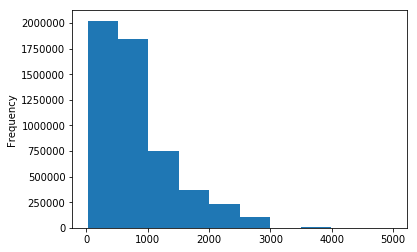

In [13]:
df['distance'].plot(kind = 'hist')

It looks like the largest group of flight distances are < 500 miles, followed byy 500-1000, then 1000+ miles. Let's create a categorical variable to understand each airline's relationship with distance.

In [14]:
#function that assigns 'short' 'medium' or 'long' based on distance
def dist_cat(x):
    if x < 500:
        return 'short'
    elif 500 <= x <= 1000:
        return 'medium'
    return 'long'

#create dist type column and count # of short/med/long flights
df['dist_type'] = df['distance'].apply(dist_cat) 
df['dist_type'].value_counts()

short     1940464
medium    1879947
long      1512503
Name: dist_type, dtype: int64

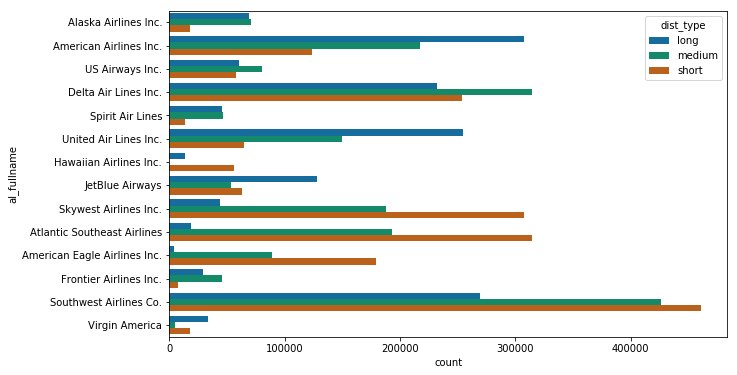

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y ='al_fullname',hue='dist_type',palette="colorblind")

After comparing more characteristics, we can derive few more insights:

1. Flight Count: Southwest Airlines Co. operated the most flights among the airlines in the dataset.They also have the highest total distance flown
2. Average Distance: Smaller carriers tend to concentrate on longer flights while larger carriers have a greater proportion of smaller flights in their portfolio. 
    Hub/spoke, may have more connecting/shorter flights, while p2p facilitates longer direct flights.

#### 2. In terms of delays, how does each airline perform?

In [16]:
# plt.figure(figsize=(10, 6))
# sns.stripplot(y="al_fullname", x="departure_delay", data=df, linewidth = 0.5,  jitter=True)

In the plot above we can see each flight's departure delay by airline.
1. We can see that the max departure delays in our dataset are ~33 and 28 hours, held by American.
2. Most airlines have a handful of catastrophic delays (>1000), but some airlines have many more than others. This could be a function of # of flights however, since the largest carriers occupy this space.

Text(0.5,0,'Average Delay [@Departure: blue, @Arrival: hatch lines]')

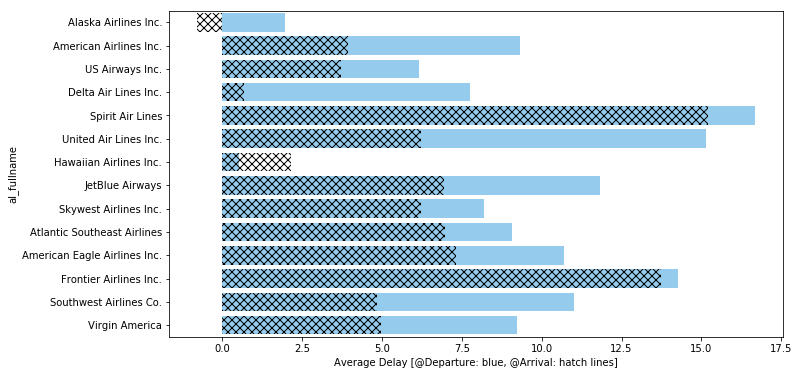

In [17]:
#credit to Daniel Fabien's Kaggle notebook listed at the top, this is a great chart!
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="departure_delay", y="al_fullname", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="arrival_delay", y="al_fullname", data=df, hatch = 'XXX', alpha = 0.0, ci=None)
plt.xlabel('Average Delay [@Departure: blue, @Arrival: hatch lines]')

In the plot above we're taking the average departure delay in light blue and imposing average arrival delay hatch lines to observe the net delay. This is a good plot to see how much departure delay time is made up in the air. 

1. Spirit airlines has the largest departure and arrival delay.
2. Alaska has the second smallest avg departure delay, and on average end up arriving slightly early. 
3. Hawaiian is the only airline whose avg net delay increases after departure, but they're still very timely.

In [18]:
#arrival + departure delays by airport
df['late_arrival'] = [1 if x >= 15 else 0 for x in df['arrival_delay']]
df['late_departure'] = [1 if x >= 15 else 0 for x in df['departure_delay']]

In [19]:
#15 destination airports with the largest average number of flights delayed  
df.groupby('destination_airport')['late_arrival'].mean().sort_values().nlargest(15)

destination_airport
STC    0.365854
PBG    0.322695
GUM    0.308383
ILG    0.306122
OTH    0.290909
ASE    0.288964
BQN    0.288161
MQT    0.285246
BPT    0.278520
TTN    0.274330
PSE    0.268975
GUC    0.264646
LBE    0.252344
LGA    0.249234
ACY    0.248390
Name: late_arrival, dtype: float64

In [20]:
#15 origin airports with the largest average number of flights delayed  
df.groupby('origin_airport')['late_departure'].mean().sort_values().nlargest(15)

origin_airport
ADK    0.416667
GST    0.402597
ILG    0.390000
MVY    0.317073
STC    0.301205
UST    0.296774
GUM    0.284431
PBG    0.274021
OTH    0.269091
CEC    0.268421
ASE    0.257720
MMH    0.243590
MDW    0.243466
BWI    0.242487
ORD    0.237194
Name: late_departure, dtype: float64

#### 3. Does airline performance change over the months of the year? In other words, is one airline always the worst performing, or is there variability?

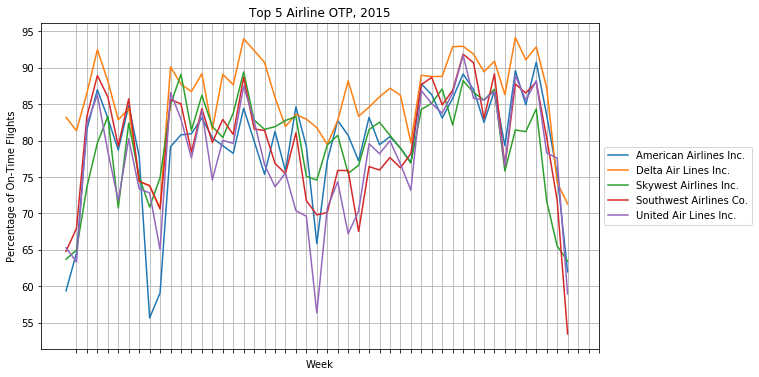

In [21]:
#calculate the percentage of on-time flights by month. (I assume on time to be no more than 15 minutes late)
on_time_performance = df.groupby(['al_fullname', 'week_number'])[['arrival_delay']].apply(lambda x: ((x <= 15).sum() / len(x)) * 100)
on_time_performance = on_time_performance.reset_index()

#subset the top 5 airlines
top_5 = df.groupby('al_fullname')['distance'].sum().sort_values(ascending = False).head(5)
top_5 = pd.DataFrame(top_5)

on_time_performance = on_time_performance[on_time_performance.al_fullname.isin(top_5.index)]

#reshape the data for plotting
pivot_table = on_time_performance.pivot(index='week_number', columns='al_fullname', values='arrival_delay')

#line plot of on-time performance by month
pivot_table.plot(kind='line', figsize=(10, 6))
plt.title('Top 5 Airline OTP, 2015')
plt.xlabel('Week')
plt.ylabel('Percentage of On-Time Flights')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(range(1, 52))
plt.grid(True)
plt.show()


In [22]:
#calculate average and standard deviation of arrival delay 
df.groupby(['al_fullname'])['arrival_delay'].agg(['mean','std']).reset_index()

,al_fullname,mean,std
0,Alaska Airlines Inc.,-0.791409,29.018948
1,American Airlines Inc.,3.935214,45.015492
2,American Eagle Airlines Inc.,7.316540,44.535512
3,Atlantic Southeast Airlines,6.964550,41.189887
4,Delta Air Lines Inc.,0.680265,39.166200
5,Frontier Airlines Inc.,13.729468,52.976344
6,Hawaiian Airlines Inc.,2.161856,25.787022
7,JetBlue Airways,6.949339,42.039092
8,Skywest Airlines Inc.,6.221438,39.747253
9,Southwest Airlines Co.,4.837831,33.227323


1. Airlines tend to trend together through time, but sometimes they are decoupled go opposite directions
2. The summer months have greater delays, but some airlines delays grow by more than others.
3. OTP appears to be higher during the later months, while almost all airlines perform worse during the summer.
4. Week/Week, average OTP hovers around 75% less peak season and holidays
 * variance calculations are subject to outliers 
 σ = sqrt(( Σ (x-μ)² ) / N ) 

#### 4. Which routes have the highest probability of being canceled?

In [23]:
df['cancelled'].value_counts(normalize=True) * 100

0    98.360559
1     1.639441
Name: cancelled, dtype: float64

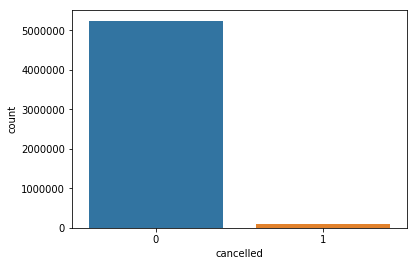

In [24]:
sns.countplot(x='cancelled', data = df)
plt.show()

For all observations, it looks like the average cancellation rate is ~1.6%. How does this vary by airline?

In [25]:
df.groupby(['al_fullname'])['cancelled'].mean().sort_values(ascending = False).reset_index()

,al_fullname,cancelled
0,American Eagle Airlines Inc.,0.054106
1,Atlantic Southeast Airlines,0.028036
2,US Airways Inc.,0.020466
3,Spirit Air Lines,0.018130
4,Skywest Airlines Inc.,0.018013
5,JetBlue Airways,0.016913
6,American Airlines Inc.,0.015715
7,United Air Lines Inc.,0.013718
8,Southwest Airlines Co.,0.013584
9,Virgin America,0.009054


In the table above we can observe the cancellation rate of each airline. Let's investigate further by analyzing...
1. Is there a specific time of day and/or time of year with a greater cancellation rate?
2. Which routes have the greatest cancellation rate?

In [26]:
#group origin-destination pairs as 'route'
df['route'] = df['origin_airport'] + '-' + df['destination_airport']

Text(0,0.5,'Cancellation Count')

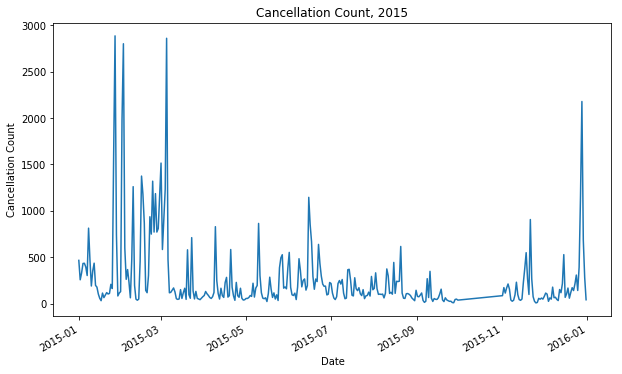

In [27]:
plt.figure(figsize=(10, 6))
df.groupby(['date'])['cancelled'].sum().sort_values(ascending = False).plot()
plt.title('Cancellation Count, 2015')
plt.xlabel('Date')
plt.ylabel('Cancellation Count')

In [28]:
#df.groupby('month')['cancelled'].sum()

It looks like there is missing data for October cancellations ^.  Can fill with average cancellations or previous month cancellations if predicting at the month level

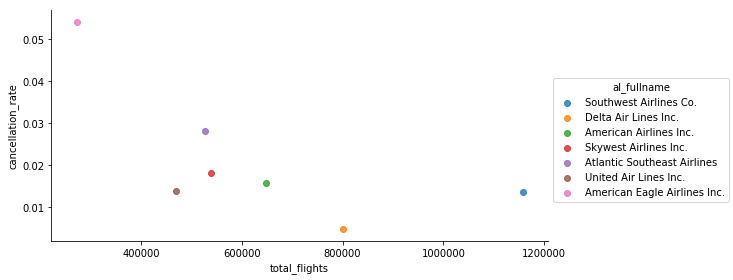

In [29]:
#count cancellations and flights for each airline
df_cancelled = df.groupby('al_fullname')['cancelled'].agg(['sum','count']).rename(columns = {'sum':'total_cancelled', 'count':'total_flights'})
df_cancelled['cancellation_rate'] = df_cancelled['total_cancelled']/df_cancelled['total_flights']


sns.lmplot(data = df_cancelled.reset_index().nlargest(7, 'total_flights'),
           x = 'total_flights', y = 'cancellation_rate', hue = 'al_fullname', 
           fit_reg = False, size = 4, aspect = 2)

In [30]:
#get average cancellations by day of week
dow_canc = df.groupby(['dow_name'])['cancelled'].mean().reset_index().rename(columns={'cancelled': 'cancellation_mean'})
dow_canc['cancellation_mean'] = dow_canc['cancellation_mean'] * 100 

#get count of flights by day of week
dow_count = df.groupby(['dow_name'])['cancelled'].count().reset_index().rename(columns={'cancelled': 'flight_count'})

#merge dataframes and print
canc_df = pd.merge(dow_canc, dow_count, on = 'dow_name')
canc_df.sort_values(by = 'flight_count')

,dow_name,cancellation_mean,flight_count
2,Saturday,1.312295,637814
3,Sunday,1.725187,754701
0,Friday,0.985112,779708
5,Tuesday,1.916482,780858
4,Thursday,1.519262,789594
6,Wednesday,1.323909,790991
1,Monday,2.618211,799248


1. From the table above we can see that in the aggregate Monday's have athe highest cancellation rate and number of flights, while Friday how the lowest cancellation rate.
2. The time trend illustrates that:
     - There 7 outlier days with > 1500 cancellations 
     - The first 3 months of the year experience the greatest # of cancellations
     - There are no cancelled flights in the dataset for October
3. Airline size doesn't necessarily correlate with lower cancellation rates

###### Considerations for forecasting cancellations:
- Keeping extreme outlier observations would cause a daily predictive model to generally over-estimate unless the outlier days can be ID'd with supplemental data like U.S. holidays, extreme weather, etc.
- Some airlines might be more cancellation elastic with respect weather or consumer demand (ex X airline has an older fleet, results in greater cancellations in poor weather compared to Y airline) Specifiying model by airline or type of airline would be useful.

### Forecasting the count of cancelled American Airlines flights.

In [34]:
#subset df to include only american airline flights
al_df = df[(df['airline'] == 'AA')]

#drop observations from october
al_df[al_df['month'] != 10]

#subset dataframe to predictive columns
#removing columns where data isn't available(e.g. departure delay isn't known for cancelled flight)
relevant_cols = ['cancelled','month','day_of_week','distance','scheduled_time', 'route', 'sched_hour']
al_df = al_df[relevant_cols]

,month,day,day_of_week,airline,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,scheduled_time,elapsed_time,distance,wheels_on,scheduled_arrival,arrival_time,arrival_delay,cancelled,al_fullname,origin_airport_name,origin_city,origin_state,origin_latitude,origin_longitude,destination_airport_name,destination_city,destination_state,destination_latitude,destination_longitude,date,week_number,dow_name,season,scheduled_departure_datetime,sched_hour,dist_type,late_arrival,late_departure,route
1,1,1,4,AA,LAX,PBI,00:10:00,00:02:00,-8.0,280.0,279.0,2330,737.0,750,07:41:00,-9.0,0,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Palm Beach International Airport,West Palm Beach,FL,26.68316,-80.09559,2015-01-01,00,Thursday,winter,2015-01-01 00:10:00,00,long,0,0,LAX-PBI
3,1,1,4,AA,LAX,MIA,00:20:00,00:15:00,-5.0,285.0,281.0,2342,748.0,805,07:56:00,-9.0,0,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Miami International Airport,Miami,FL,25.79325,-80.29056,2015-01-01,00,Thursday,winter,2015-01-01 00:20:00,00,long,0,0,LAX-MIA
8,1,1,4,AA,SFO,DFW,00:30:00,00:19:00,-11.0,195.0,193.0,1464,529.0,545,05:32:00,-13.0,0,American Airlines Inc.,San Francisco International Airport,San Francisco,CA,37.61900,-122.37484,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,32.89595,-97.03720,2015-01-01,00,Thursday,winter,2015-01-01 00:30:00,00,long,0,0,SFO-DFW
11,1,1,4,AA,LAS,MIA,00:35:00,00:27:00,-8.0,268.0,266.0,2174,746.0,803,07:53:00,-10.0,0,American Airlines Inc.,McCarran International Airport,Las Vegas,NV,36.08036,-115.15233,Miami International Airport,Miami,FL,25.79325,-80.29056,2015-01-01,00,Thursday,winter,2015-01-01 00:35:00,00,long,0,0,LAS-MIA
21,1,1,4,AA,SEA,MIA,01:00:00,00:52:00,-8.0,338.0,347.0,2724,933.0,938,09:39:00,1.0,0,American Airlines Inc.,Seattle-Tacoma International Airport,Seattle,WA,47.44898,-122.30931,Miami International Airport,Miami,FL,25.79325,-80.29056,2015-01-01,00,Thursday,winter,2015-01-01 01:00:00,01,long,0,0,SEA-MIA
23,1,1,4,AA,LAX,MIA,01:05:00,01:03:00,-2.0,286.0,276.0,2342,832.0,851,08:39:00,-12.0,0,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,33.94254,-118.40807,Miami International Airport,Miami,FL,25.79325,-80.29056,2015-01-01,00,Thursday,winter,2015-01-01 01:05:00,01,long,0,0,LAX-MIA
29,1,1,4,AA,DEN,MIA,01:20:00,01:41:00,21.0,227.0,208.0,1709,701.0,707,07:09:00,2.0,0,American Airlines Inc.,Denver International Airport,Denver,CO,39.85841,-104.66700,Miami International Airport,Miami,FL,25.79325,-80.29056,2015-01-01,00,Thursday,winter,2015-01-01 01:20:00,01,long,0,1,DEN-MIA
31,1,1,4,AA,PHX,MIA,01:27:00,01:16:00,-11.0,239.0,234.0,1972,703.0,726,07:10:00,-16.0,0,American Airlines Inc.,Phoenix Sky Harbor International Airport,Phoenix,AZ,33.43417,-112.00806,Miami International Airport,Miami,FL,25.79325,-80.29056,2015-01-01,00,Thursday,winter,2015-01-01 01:27:00,01,long,0,0,PHX-MIA
42,1,1,4,AA,PHX,DFW,02:00:00,None,NaN,120.0,NaN,868,NaN,500,None,NaN,1,American Airlines Inc.,Phoenix Sky Harbor International Airport,Phoenix,AZ,33.43417,-112.00806,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,32.89595,-97.03720,2015-01-01,00,Thursday,winter,2015-01-01 02:00:00,02,medium,0,0,PHX-DFW
64,1,1,4,AA,MCO,MIA,05:10:00,05:07:00,-3.0,63.0,55.0,192,559.0,613,06:02:00,-11.0,0,American Airlines Inc.,Orlando International Airport,Orlando,FL,28.42889,-81.31603,Miami International Airport,Miami,FL,25.79325,-80.29056,2015-01-01,00,Thursday,winter,2015-01-01 05:10:00,05,short,0,0,MCO-MIA


In [36]:
#add day of week, route, hour, month dummy variables
day_dummys = pd.get_dummies(al_df['day_of_week'], prefix = 'day')
route_dummys = pd.get_dummies(al_df['route'], prefix = 'route')
month_dummys = pd.get_dummies(al_df['month'], prefix = 'month')
hour_dummys = pd.get_dummies(al_df['sched_hour'], prefix = 'hour')


#concat dummy vars to dataframe
al_df = pd.concat([al_df, day_dummys, month_dummys, hour_dummys, route_dummys], axis = 1)
al_df = al_df.drop(columns = ['month','day_of_week', 'route', 'sched_hour'])

#split data into features + target
X = al_df.drop('cancelled', 1)
y = al_df.cancelled

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#split feature and target data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=60)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.98


In [40]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[191526      0]
 [  3083      0]]


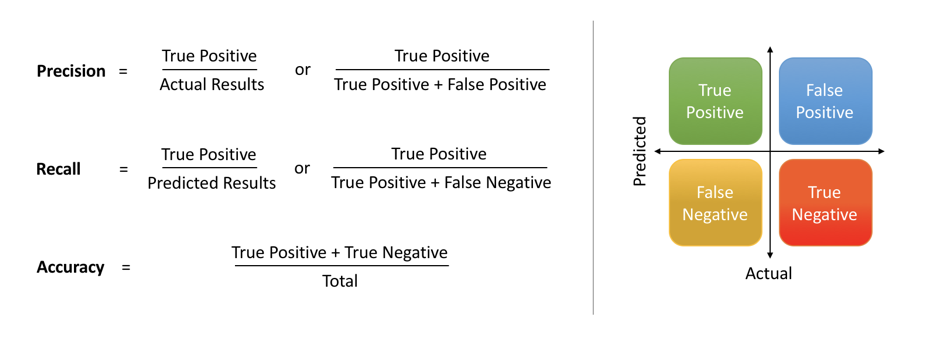

In [41]:
print(classification_report(y_test, y_pred, target_names=["NOT CANCELLED", "CANCELLED"]))

               precision    recall  f1-score   support

NOT CANCELLED       0.98      1.00      0.99    191526
    CANCELLED       0.00      0.00      0.00      3083

  avg / total       0.97      0.98      0.98    194609



### Summary
Given the limited data available before a flight takes off (route, day of week, month, scheduled_hour) our model has a hard time discerning which flights would be cancelled. This makes intuitive sense as each route has several flights happen each day, and the features available aren't going to vary distinctly between cancelled/not cancelled flights (e.g. cancellations are probably distributed evenly across distance). The model achieves very high precision by predicting each flight is not cancelled, but this metric is not super informative. Recall for the number correctly identified cancellations would be more helpful since there are a very small number of anomolies and might sacrifice some precision to make the model more sensitive to them. 

Additional information that might improve the forecast:
1. Weather data at scheduled departure (wet bulb temp, precipitation, etc).
2. Aircraft age, might inform whether flight could be cancelled due to mechanical issues.
3. Holiday dummy variable, seasonal demand could affect ability to maintain schedules.